In [1]:
import torch
import util
import custum_dataset
from torch.utils.data import DataLoader
from model import Model,save_model
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt


# 1.setting up

In [2]:
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = f'C:/Users/yy/Desktop/dl_project/data/data.txt'  

c = util.config()

data_train,stoi,itos = util.load_data_with_split(path,c.split,type='train')
data_test,_,_ = util.load_data_with_split(path,c.split,type='test')


dataset_train = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_train,repeat = False)
data_loader_train = DataLoader(dataset_train, c.batch_size, shuffle=True)
dataset_test = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_test,repeat = False)
data_loader_test = DataLoader(dataset_test, c.batch_size, shuffle=True)

m = Model(stoi=dataset_train.stoi).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=c.learning_rate)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.1, patience=5)
nb_epoch = 4000

milestones = np.arange(0,nb_epoch,50)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones, 0.1)
MODEL_NAME = str(nb_epoch)+"epoch_model_seed42_no_lrd.pth"

# 2. train and evaluate

In [3]:
train_data_iterator = iter(data_loader_train)
test_data_iterator = iter(data_loader_test)
train_loss_list = []
test_loss_list = []
perplexity_train_list = []
perplexity_test_list = []

for epoch in range(nb_epoch):
    m.train()
    x,y = next(train_data_iterator)
    logit, loss, perplexity = m(x,use='train',y = y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    m.eval()
    with torch.inference_mode():
        x_t,y_t = next(test_data_iterator)
        test_logit, test_loss, test_perplexity = m(x_t, use='train', y=y_t)

    if epoch%50 == 0:
        print(f"Epoch {epoch + 1}/{nb_epoch}, Loss: {loss:.4f}, Perplexity: {perplexity:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Perplexity: {test_perplexity:.4f}")

#    scheduler.step()
    train_loss_list.append(loss.cpu().detach().numpy())
    test_loss_list.append(test_loss.cpu().detach().numpy())
    perplexity_train_list.append(perplexity.cpu().detach().numpy())
    perplexity_test_list.append(test_perplexity.cpu().detach().numpy())

save_model(m, MODEL_NAME)


Epoch 1/4000, Loss: 4.3329, Perplexity: 76.1671
Test Loss: 3.6897, Test Perplexity: 40.0345
Epoch 51/4000, Loss: 2.5924, Perplexity: 13.3622
Test Loss: 2.5656, Test Perplexity: 13.0079
Epoch 101/4000, Loss: 2.4854, Perplexity: 12.0062
Test Loss: 2.4952, Test Perplexity: 12.1241
Epoch 151/4000, Loss: 2.4501, Perplexity: 11.5893
Test Loss: 2.4904, Test Perplexity: 12.0664
Epoch 201/4000, Loss: 2.4184, Perplexity: 11.2283
Test Loss: 2.4437, Test Perplexity: 11.5156
Epoch 251/4000, Loss: 2.3522, Perplexity: 10.5085
Test Loss: 2.3927, Test Perplexity: 10.9435
Epoch 301/4000, Loss: 2.2863, Perplexity: 9.8387
Test Loss: 2.3362, Test Perplexity: 10.3417
Epoch 351/4000, Loss: 2.2069, Perplexity: 9.0873
Test Loss: 2.2439, Test Perplexity: 9.4304
Epoch 401/4000, Loss: 2.1321, Perplexity: 8.4326
Test Loss: 2.1929, Test Perplexity: 8.9612
Epoch 451/4000, Loss: 2.0572, Perplexity: 7.8243
Test Loss: 2.1477, Test Perplexity: 8.5649
Epoch 501/4000, Loss: 1.9932, Perplexity: 7.3387
Test Loss: 2.0927, Te

# 3. Plot loss and perplexity 

Text(0, 0.5, 'perplexity')

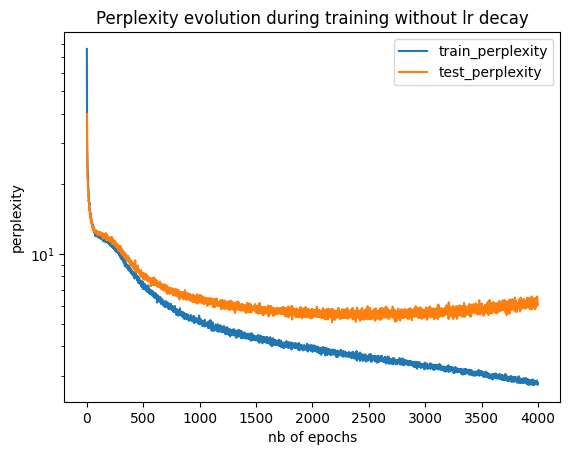

In [9]:
epoch_list = np.arange(0,len(perplexity_train_list))
plt.plot(epoch_list,perplexity_train_list)
plt.plot(epoch_list,perplexity_test_list)
plt.yscale("log")
plt.title('Perplexity evolution during training without lr decay')
plt.legend(['train_perplexity','test_perplexity'])
plt.xlabel('nb of epochs')
plt.ylabel('perplexity')

Text(0, 0.5, 'cross entropy loss')

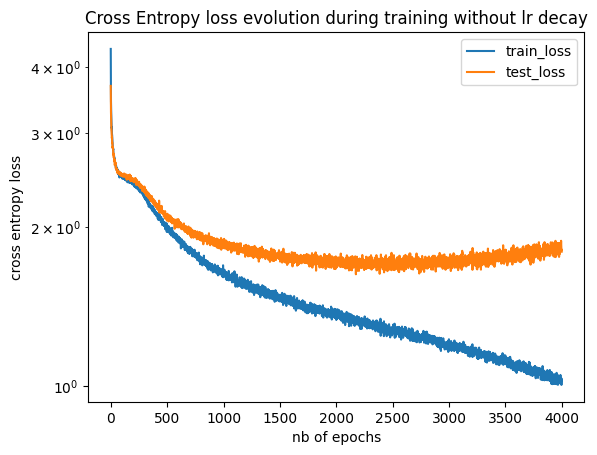

In [10]:
epoch_list = np.arange(0,len(train_loss_list))
plt.plot(epoch_list,train_loss_list)
plt.plot(epoch_list,test_loss_list)
plt.yscale("log")
plt.title('Cross Entropy loss evolution during training without lr decay')
plt.legend(['train_loss','test_loss'])
plt.xlabel('nb of epochs')
plt.ylabel('cross entropy loss')



In [12]:
nb_char = 3000

seed = "I saw a dumb cat holding an apple on its head, "
input_idx = util.encode(seed,stoi)

input_idx = torch.tensor(input_idx,dtype=torch.long)
input_idx = torch.unsqueeze(input_idx, 0).to(device)


In [13]:
m.eval()
with torch.no_grad():
    out = m.generate(nb_char,input_idx,'sample')
    out = util.decode(out,itos)
    
print(out)
util.save_generated_text('output'+str(nb_epoch)+'_epochs_sample_no_lr_d.txt',out)

I saw a dumb cat holding an apple on its head, by his
hand that his kept: his safely would company
Of my head most bears; heaven many voice
A choice of them; and all the common peers,
Soverhoward with rudel and up, and sake dealing,
And ofter prayers with her grave here.

GLOUCESTER:
Here, he's dismal your part.

LADY ANNE:
So far is in brother thou thy bosom.

LORD ROSS:
Thy king is sin worm in thy heavy seek!

RATCLIFF:
Where is Richard, upon the right forth
Your choice, then giving your man's name.

JULIET:
Into the precious peace!

Nurse:
Go Romeo, for the Tower, respected with her.

LADY ANNE:
No dismatter's hand!

KING RICHARD II:
That is a guard common dead.

LARTIUS:
The general know, lords, to hear the city,
And sickly seven from serve me truth on ground
The Bretand kingmen and recreant deny.

LADY ANNE:
Why, dost so? call we are a month home
So have content with him: and his complity
Reman, and suffer love his purpose and love me
I need!

First Senator:
Do you by my unhappied

In [8]:
m.eval()
with torch.no_grad():
    out = m.generate(nb_char,input_idx,'high_prob')
    out = util.decode(out,itos)
print(out)

util.save_generated_text('output'+str(nb_epoch)+'epochs_high_prob_no_lr_d.txt',out)




I saw a dumb cat holding an apple on its head, and the signority
That in the envious sickness of heaven
The second confession of the stones are all
The people's enemy is a peace. Yet the common short
That would be consul.

SICINIUS:
The sharp of that shall be so.

MENENIUS:
I would the sun that I had rather here,
That I had been so love a soldier,
And then did I see the dead of a man
To should be a prodignt for a good consent.

LADY ANNE:
Why, then, give me leave to repent.

GLOUCESTER:
Why, then, then, the county servant thou hast
Thou wilt be married to make him should be a breath,
And the rest did hate the common of his country.

SICINIUS:
He shall be so.

MENENIUS:
He had not so.

CORIOLANUS:
I do beseech you, sir.

CORIOLANUS:
I do beseech you, sir.

CORIOLANUS:
I do beseech you, sir.

MENENIUS:
I will not so.

CORIOLANUS:
I will not share you, sir.

CORIOLANUS:
I do beseech you, sir, it is not so.

SICINIUS:
He shall be so.

CORIOLANUS:
I will not share you, sir.

CORIOLANUS:
I d